In [1]:
import Demo
import Data.Massiv.Array as A
import Data.Massiv.Array.IO as A
import Data.Massiv.Array.Numeric.Integral
import Data.Text as T (pack)
import Graphics.Color.Space
import Graphics.Color.Illuminant.CIE1931 as CIE1931
import Graphics.Vega.VegaLite as VL hiding (Color)
import IHaskell.Display.Hvega
import IHaskell.Display (latex)
import Control.Monad as Monad
import Data.Foldable as F

:set -XOverloadedStrings
:set -XDataKinds
:set -XPolyKinds

1.1910429723971884e-16

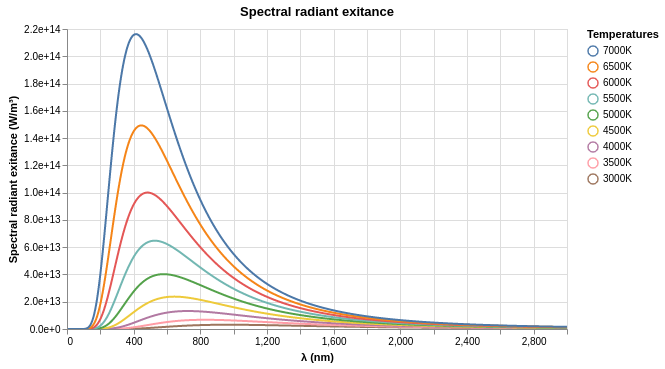

In [2]:
-- | Function for computing black body spectral radiant exitance
spectralRadiantExitanceGeneral
  :: Double -- ^ c1 - first radiation constant
  -> Double -- ^ c2 - second radiation constant
  -> Double -- ^ T - Temperature in Kelvin
  -> Double -- ^ λ - Wavelength in meters
  -> Double -- ^ watt per square meter per meter (W/m3)
spectralRadiantExitanceGeneral c1 c2 temperature lambda = (c1 / (lambda ^ (5 :: Int))) / 
                                                          (exp (c2 / (lambda * temperature)) - 1)

spectralRadiantExitance temperature lambda = spectralRadiantExitanceGeneral c1 c2 temperature lambda'
  where
    lambda' = lambda * 1e-9 -- wavelength: m
    c = 2.99792458e8 -- speed of light: m / s
    h = 6.62607015e-34 -- Planck's constant: J * s
    k = 1.380649e-23 -- Boltzmann's constant: J / K
    c1 = 2 * pi * h * (c ^ (2 :: Int)) -- W * m^2
    c2 = h * c / k -- K * m



spectralRadiantExitanceHistoric c2 temperature lambda = spectralRadiantExitanceGeneral c1 c2 temperature lambda'
  where
    lambda' = lambda * 1e-9 -- wavelength: m
    c = 299792458 -- speed of light m / s
    k = 1.380649e-23 -- Boltzmann's constant: J / K
    -- Normal formula for c1, but we want to compute it from c2 instead
    c1 = 2 * pi * h * (c ^ (2 :: Int))
    h = c2 * k / c --  Derive Planck's constant from second radiation constant


spectralRadianExitancePlot = toVegaLite
  [ title "Spectral radiant exitance" []
  , background "white"
  , height 300
  , width 500
  , mark Line []
  , dataFromColumns []
    . dataColumn "λ (nm)" (Numbers wavelengths)
    . foldl mkColumn id temperatures
    $ []
  , transform . foldAs (fst <$> temperatures) "Temperatures" "Spectral radiant exitance (W/m³)" $ []
  , encoding 
    . position VL.X [PName "λ (nm)", PmType Quantitative]
    . position VL.Y [PName "Spectral radiant exitance (W/m³)", PmType Quantitative, PAxis [AxFormat ".1e"]]
    . color [ MName "Temperatures", MmType Nominal, MSort [Descending]]
    $ []
  ]
  where
    temperatures = [(T.pack (show (round t)) <> "K", t) | t <- [3000, 3500 .. 7000]]
    wavelengths = [0, 5 .. 3000 :: Double]
    mkColumn acc (tname, t) = dataColumn tname (Numbers (spectralRadiantExitance t <$> wavelengths)) . acc

c = 2.99792458e8 -- speed of light: m / s
h = 6.62607015e-34 -- Planck's constant: J * s
k = 1.380649e-23 -- Boltzmann's constant: J / K
c1 = 2 * h * (c ^ (2 :: Int))

print c1

latex "$M(\\lambda,T) =\\frac{c_{1}}{\\lambda^5}\\frac{1}{\\exp\\left(\\frac{c_2}{{\\lambda}T}\\right)-1}$"
latex "${c_{1}} = 2\\pi hc^2$"
latex "${c_{2}} = \\frac{hc}{k}$"

-- print (spectralRadiantExitanceGeneral 1.191042759e-16 1.4387752e-2 6500 0.0000005)
-- print (spectralRadiantExitanceGeneral 1.191042759e-16 1.4387752e-2 6500 (500 * 1e-9))
-- print $ spectralRadiantExitance 6500 500
-- print $ spectralRadiantExitanceHistoric 1.4388e-2 6500 500
vlShow spectralRadianExitancePlot

In 1931: c2 = 1.435e-2

Today:   c2 = 1.4387768775039337e-2

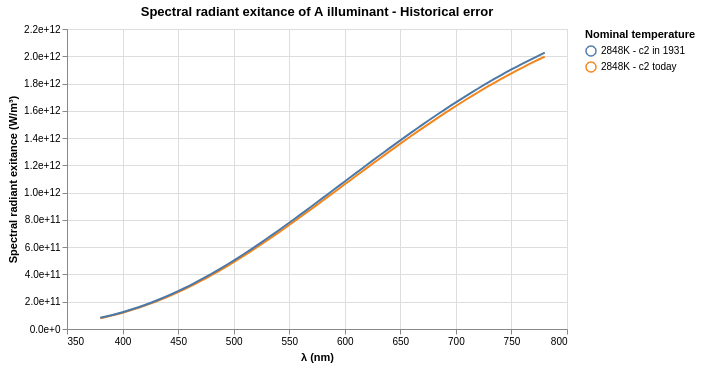

In [3]:
-- Values for c2:
_c2_ITS_27 = 1.432e-2 -- ITS-27 (from 1927)
_c2_CIE1931 = 1.435e-2 -- Used for A B C (1931) - value suggested by U.S. National Bureau of Standards
_c2_IPTS_48 = 1.4380e-2 -- IPTS-48 was used for D illuminants in 1967
_c2_ITS_68 = 1.4388e-2 -- ITS-68 and ITS-90
_c2_CODATA_2006 = 1.4387752e-2 -- (CODATA-1998 - CODATA-2006) - Standard uncertainty 0.0000025, relative standard uncertainty: 1.7e-6
_c2_CODATA_2010 = 1.438777013131313e-2
_c2_CODATA_2014 = 1.4387773683838383e-2
_c2_CODATA_2018 = 1.438776877e-2 -- Source: https://physics.nist.gov/cgi-bin/cuu/Value?c22ndrc
_c2_computed = 6.62607015e-34 * 2.99792458e8 / 1.380649e-23 -- h * c / k = 1.4387768775039337e-2

spectralRadiantExitanceVisiblePlot = toVegaLite
  [ title "Spectral radiant exitance of A illuminant - Historical error" []
  , background "white"
  , height 300
  , width 500
  , mark Line []
  , dataFromColumns []
    . dataColumn "λ (nm)" (Numbers wavelengths)
    . foldl mkColumn id temperatures
    $ []
  , transform . foldAs (concat [[tn <> " - c2 today", tn <> " - c2 in 1931"] | (tn, _) <- temperatures])
                "Nominal temperature" "Spectral radiant exitance (W/m³)" $ []
  , encoding 
    . position VL.X [PName "λ (nm)", PmType Quantitative]
    . position VL.Y [PName "Spectral radiant exitance (W/m³)", PmType Quantitative, PAxis [AxFormat ".1e"]]
    . color [ MName "Nominal temperature", MmType Nominal ]
    $ []
  ]
  where
    temperatures = [(T.pack (show (round t)) <> "K", t) | t <- [2848]]
    wavelengths = [w | (w, _, _) <- CIE1931.xyzColorMatchingFunctions]
    mkColumn acc (tname, t) = dataColumn (tname <> " - c2 today") (Numbers (spectralRadiantExitance t <$> wavelengths)) .
                              dataColumn (tname <> " - c2 in 1931") (Numbers (spectralRadiantExitanceHistoric _c2_CIE1931 t <$> wavelengths)) . acc

putStrLn ("In 1931: c2 = " <> show _c2_CIE1931)
putStrLn ("Today:   c2 = " <> show _c2_computed)

vlShow spectralRadiantExitanceVisiblePlot

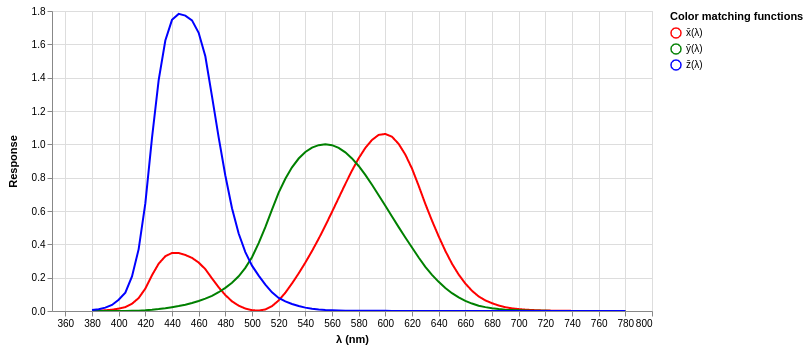

In [14]:
colorMatching :: Array P Ix2 Double
colorMatching = A.compute $ A.makeLoadArrayS (Sz (length CIE1931.xyzColorMatchingFunctions :. 4)) 0 $ \ writeCell ->
  let writeColumn i (w, V3 x y z, _) = do
            writeCell (i :. 0) w
            writeCell (i :. 1) x
            writeCell (i :. 2) y
            writeCell (i :. 3) z
  in Monad.zipWithM_ writeColumn [0..] CIE1931.xyzColorMatchingFunctions 

colorMatchingPlot = toVegaLite
  [ description "CIE1931 XYZ 2° Observer Color Matching Functions"
  , background "white"
  , height 300
  , width 600
  , dataFromColumns []
    . dataColumn "λ (nm)" (Numbers (A.toList (colorMatching <! 0)))
    . dataColumn "x̄(λ)" (Numbers (A.toList (colorMatching <! 1)))
    . dataColumn "ȳ(λ)" (Numbers (A.toList (colorMatching <! 2)))
    . dataColumn "z̄(λ)" (Numbers (A.toList (colorMatching <! 3)))
    $ []
  , transform . foldAs ["x̄(λ)", "ȳ(λ)", "z̄(λ)"] "Color matching functions" "Response" $ []
  , mark Line []
  , encoding 
    . position VL.X [PName "λ (nm)", PmType Quantitative]
    . position VL.Y [PName "Response", PmType Quantitative]
    . color [ MName "Color matching functions"
            , MmType Nominal
            , MScale [SDomain (DStrings ["x̄(λ)", "ȳ(λ)", "z̄(λ)"]), SRange (RStrings ["Red", "Green", "Blue"])]
            ]
    $ []
  ]

vlShow colorMatchingPlot

In [4]:
import Data.Bifunctor (first)
import Data.List as L

integrate :: Array P Ix1 Double -> Double
integrate arr = fst $ A.foldlS sumWith (0, y0') arr'
    where
      Just (y0', arr') = unconsM arr
      step = 1e-9
      area y0 y1 = step * (y0 + y1) / 2
      sumWith (acc, y0) y1 =
        let acc' = acc + area y0 y1
         in acc' `seq` (acc', y1)

planckianLocus :: Double -> Double -> Color (XYZ 'D65) Double
planckianLocus c2 temperature = xyz -- (ls, x, y , z)
  where ls = A.computeAs P $ A.map (spectralRadiantExitanceHistoric c2 temperature) (colorMatching <! 0)
        x = either throw (integrate . A.computeAs P) (delay ls .*. delay (colorMatching <! 1))
        y = either throw (integrate . A.computeAs P) (delay ls .*. delay (colorMatching <! 2))
        z = either throw (integrate . A.computeAs P) (delay ls .*. delay (colorMatching <! 3))
        xyz = ColorXYZ x y z


spanMaybe :: (b -> a -> Maybe b) -> b -> [a] -> ([b], [a])
spanMaybe f x0 = first L.reverse . go x0 []
  where go x xs []     = (x:xs, [])
        go x xs (y:ys) = case f x y of
                           Nothing -> (x:xs, y:ys)
                           Just x' -> go x' (x:xs) ys

spanMaybe1 :: (a -> a -> Maybe a) -> [a] -> ([a], [a])
spanMaybe1 _ []     = ([], [])
spanMaybe1 f (x:xs) = spanMaybe f x xs

planckianLocusPlot = toVegaLite
  [ title "CIE 1931 Planckian Locus" []
  , background "white"
  , height 600
  , width 500
  , layer
    [ asSpec planckianLocusSpec
    , asSpec $ mkLocus top "Top"
    , asSpec $ mkLocus bottom "Bottom"
    ]
  ]
  where
    ts = [0, 100 .. 50000]
    xys = fromColorXYZ . planckianLocus _c2_computed <$> ts :: [Color (CIExyY 'D65) Double]
    planckianLocusSpec =
      [ mark Line [MColor "Red"]
      , dataFromColumns []
        . dataColumn "x" (Numbers [x | ColorCIExy x _ <- xys])
        . dataColumn "y" (Numbers [y | ColorCIExy _ y <- xys])
        $ []
      , encoding 
        . position VL.X [PName "x", PTitle "x", PmType Quantitative]
        . position VL.Y [PName "y", PTitle "y", PmType Quantitative]
        $ []
      ]
    (bottom, top) = -- split the horseshoe locus into two sections for plotting
      connectDots $ spanMaybe1 (\(_, V2 x' _) cs@(_, V2 x _) -> if x' > x then Just cs else Nothing) 
                               [(w, xy) | (w, _, xy) <- CIE1931.xyzColorMatchingFunctions]
    connectDots (xs, ys) = let xs' = L.reverse (last ys : xs) in (xs', head xs' : ys)
    mkLocus coords sectionName = 
      [ mark Line [MColor "Black"]
      , dataFromColumns []
        . dataColumn ("gx" <> sectionName) (Numbers [x | (_, V2 x _) <- coords])
        . dataColumn ("gy" <> sectionName) (Numbers [y | (_, V2 _ y) <- coords])
        $ []
      , encoding      
        . position VL.X [PName ("gx" <> sectionName), PNoTitle, PmType Quantitative]
        . position VL.Y [PName ("gy" <> sectionName), PNoTitle, PmType Quantitative]
        $ []
      ]
fromColorXYZ $ planckianLocus _c2_ITS_68 (unCCT (colorTemperature :: CCT 'D65)) :: Color (CIExyY 'D65) Double
fromColorXYZ $ planckianLocus _c2_IPTS_48 6548.6 :: Color (CIExyY 'D65) Double
fromColorXYZ $ planckianLocus _c2_ITS_68 6500 :: Color (CIExyY 'D65) Double

xc t = (-3.0258469) * (10 ^ (9 :: Int)) / (t ^ (3 :: Int)) + 2.1070379 * (10 ^ (6 :: Int)) / (t ^ (2 :: Int)) + 0.2226347 * (10 ^ (3 :: Int)) / t + 0.24039

print $ xc 6504
print (whitePoint :: WhitePoint 'D65 Double)

--vlShow planckianLocusPlot


-- wavelength :: Array P Ix2 Double
-- wavelength = A.createArrayST_ Seq (Sz (length CIE1931.colorMatchingFunctions :. 4)) $ \ ma ->
--   let writeColumn i (w, V3 x y z, _) = do writeM ma (i :. 0) w
--                                           writeM ma (i :. 1) x
--                                           writeM ma (i :. 2) y
--                                           writeM ma (i :. 3) z
--   in Monad.zipWithM_ writeColumn [0..] CIE1931.colorMatchingFunctions 

-- :set -XDataKinds
-- :set -XPolyKinds
-- planckianLocus :: Double -> Color (XYZ 'D65) Double
-- planckianLocus temperature = xyz -- / pure (minimum xyz)
--   where ls = A.computeAs P $ A.map ((5 *) . spectralRadiantExitance temperature) (wavelengths <! 0)
--         x = either throw A.sum (delay ls .*. delay (wavelengths <! 1) >>= (.*.) (delay (wavelengths <! 0)))
--         y = either throw A.sum (delay ls .*. delay (wavelengths <! 2) >>= (.*.) (delay (wavelengths <! 0)))
--         z = either throw A.sum (delay ls .*. delay (wavelengths <! 3) >>= (.*.) (delay (wavelengths <! 0)))
--         xyz = ColorXYZ x y z
-- fromColorXYZ $ planckianLocus 6500 :: Color (CIExyY 'D65) Double
-- print (whitePoint :: WhitePoint 'D65 Double)

: 

In [52]:
4.135667696e-15 * 2.99792458e8 / 8.617333262145e-15

1.438776877182558e8

In [ ]:
1.438777013131313e-2 :: Double

In [ ]:
1.4387773683838383e-2
1.438777368383838383e-2